In [101]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

Names and PRN for all group members:
- Name: Amit Kumar Gupta
- PRN:  240840128006
- Date: 6Dec,2024

# Deep Neural Networks
## A07: Group Assignment


##  Convolutional Neural Network (CNN)

- Flowers Dataset


In [102]:
###-----------------
### Import Libraries
###-----------------

#!/usr/bin/env pyhton3
# -*- coding

from sklearn import datasets
from sklearn.model_selection import train_test_split
###-----------------
### Import Libraries
###-----------------
import os
import time
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import matplotlib.pyplot as plt
import tensorflow as tf
import torch

import gc
import torch.nn as nn
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [103]:
###----------------------
### Some basic parameters
###----------------------
# Global variables
inpDir = './input' # Input Stored here
outDir = './ouput' # output Here
modelDir = './models'# to save Models
subDir = 'flower_photos' # sub dir by dataset
altName = 'base_model'
RANDOM_STATE = 24
np.random.RandomState(seed = RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
#rng = np.random.default_rng(seed = RANDOM_STATE)
#N_SAMPLE = 1000
TEST_SIZE = 0.2 # 18147 - 56*256
ALPHA = 0.001 # learning rate
NOISE = 0.2 # Error
EPOCHS = 60
BATCH_SIZE = 16

PATIENCE = 20
LR_FACTOR  =0.1
LR_PATIENCE = 10
IMG_HEIGHT = 188
IMG_WIDTH = 188

In [104]:
#set the plotting parameters
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }
    #'text.usetex':True,

plt.rcParams.update(params)
CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid')


## Load Dataset

Images are under flower_photos

     |- daisy
     |- dandelion
     |- roses
     |- sunflowers
     |- tulips

In [105]:
'''
    For reading from web link
'''

import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                  fname='flower_photos',
                                  untar=True)
data_dir = pathlib.Path(data_dir)
'''
    For reading from local directory
'''
# data_dir = os.path.join(inpDir, subDir)

'\n    For reading from local directory\n'

In [106]:
data_dir

PosixPath('/root/.keras/datasets/flower_photos')

In [107]:
os.listdir(data_dir)

['LICENSE.txt', 'roses', 'tulips', 'daisy', 'dandelion', 'sunflowers']

In [108]:
def fn_plot_tf_hist(hist_df):

    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: accuracy
            column 1: loss
            column 2: val_accuracy
            column 3: val_loss
            While plotting columns are accessed by index
            so that even if the column names are different it will not throw exceptions.
    '''

    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm

    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y4] == hist_df[y4].min()]

    ax = axes[0]

    hist_df.plot(y = [y2,y4], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = '{:s}: \n  train: {:6.4f}\n   test: {:6.4f}'
    txtstr = txtFmt.format(y2.capitalize(),
                           hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0] + offset), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3)

    ax.set_xlabel('Epochs')
    ax.set_ylabel(y2.capitalize())
    ax.set_title('Errors')
    ax.grid(True)
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y1, y3], ax = ax, colormap=CMAP)

    # little beautification
    txtFmt = '{:s}: \n  train: {:6.4f}\n  test:  {:6.4f}'
    txtstr = txtFmt.format(y1.capitalize(),
                           hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0]-offset), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow


    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3)

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.grid(True)
    ax.legend(loc = 'lower left')

    plt.tight_layout()


In [109]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
     data_dir,
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT,IMG_WIDTH),
    subset='training',
    seed = RANDOM_STATE,
    validation_split=TEST_SIZE,


)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [110]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
     data_dir,
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT,IMG_WIDTH),
    subset='validation',
    seed = RANDOM_STATE,
    validation_split=TEST_SIZE,


)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [111]:
#Is it getting the class names

class_names = train_ds.class_names
num_classes = len(class_names)
display(class_names, num_classes)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

5

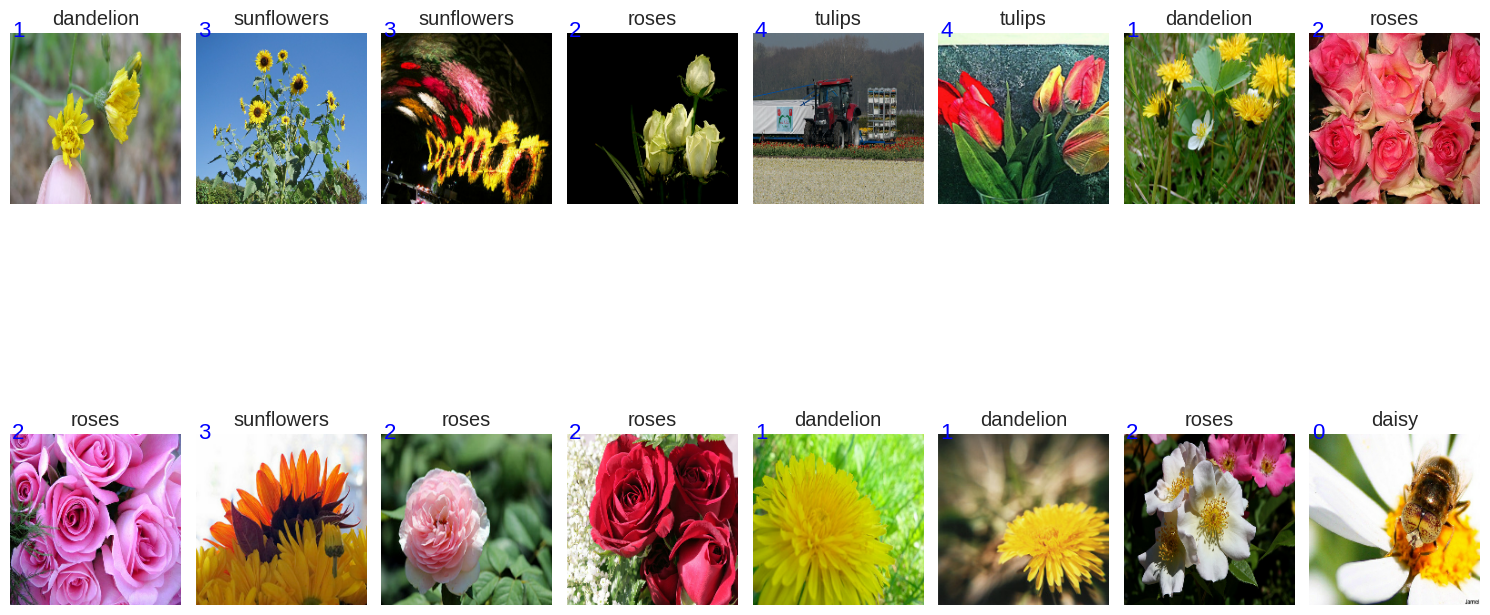

In [112]:
# sample DATA plot: Display a grid of images from the dataset along with their labels



#create a new figure for the grid of images with a specified size
fig = plt.figure(figsize  =(15,12))

#Adjust Margins
fig.subplots_adjust(left = 0, right = 1, bottom=0, top = 1, hspace =0.05, wspace = 0.05)
i= 0
for images, labels in train_ds.take(1):
    for i in range(BATCH_SIZE):
        plt.subplot(BATCH_SIZE// 8,8, i+1)
        plt.grid(False)

        plt.imshow(images[i].numpy().astype('uint8'), cmap = plt.cm.binary)

        # Add the numeric label to the image in blue text at a specific position
        plt.title(class_names[labels[i].numpy()])


        # Add the class name of the image in red text below the numeric label
        plt.text(2,4, labels[i].numpy(), color = 'b', fontsize=16)
    #SWITCH OF AXIS
        plt.axis('off')
plt.tight_layout()
#Display the entire frid of images
plt.show()

In [113]:
def fn_plot_label(tr_ds, ts_ds, class_names = None):

    '''
        Args:
            tr_ds :  Training Dataset
            ts_ds : Testing dataset
            class_names : Class names
        Returns : none
    '''

    # create figure and axes
    fig, axes = plt.subplots(1,2, figsize = (15,5))

    # get names of the classes
    if not class_names:
        tr_class_names = tr_ds.class_names
        ts_class_names = tr_ds.class_names

    # pick first axis
    ax = axes[0]

    # create dict of training labels
    class_counts = {}
    for imgs, lbls in tr_ds:
        for lbl in lbls.numpy():
            class_counts[lbl] = class_counts.get(lbl, 0) +1

    # bar plot
    ax.bar(tr_class_names, [class_counts.get(i, 0) for i in range(len(tr_class_names))],
           align='center',color = 'DarkBlue', alpha = 0.7)

    # add title
    ax.set_title('Training Set')

    # grids make it look good
    ax.grid(True)


    #pick second image
    ax = axes[1]

    # create dict of training labels
    class_counts = {}
    for imgs, lbls in ts_ds:
        for lbl in lbls.numpy():
            class_counts[lbl] = class_counts.get(lbl, 0) +1

    # bar plot
    ax.bar(ts_class_names, [class_counts.get(i, 0) for i in range(len(ts_class_names))],
           align='center',color = 'orange', alpha = 0.7)

    # add title
    ax.set_title('Test Set')


    # grids make it look good
    ax.grid(True)

    # fit the subplot(s) in to the figure area
    plt.tight_layout()

    # display all open figures
    plt.show()

###-------------------------------
### Convert datetime from a string
###-------------------------------
def fn_convert_timestamp(tstr):
    '''
        Function to conver string of form "2015-11-12 1444"
    '''

    return datetime.strptime(tstr, "%Y-%m-%d_%H%M")



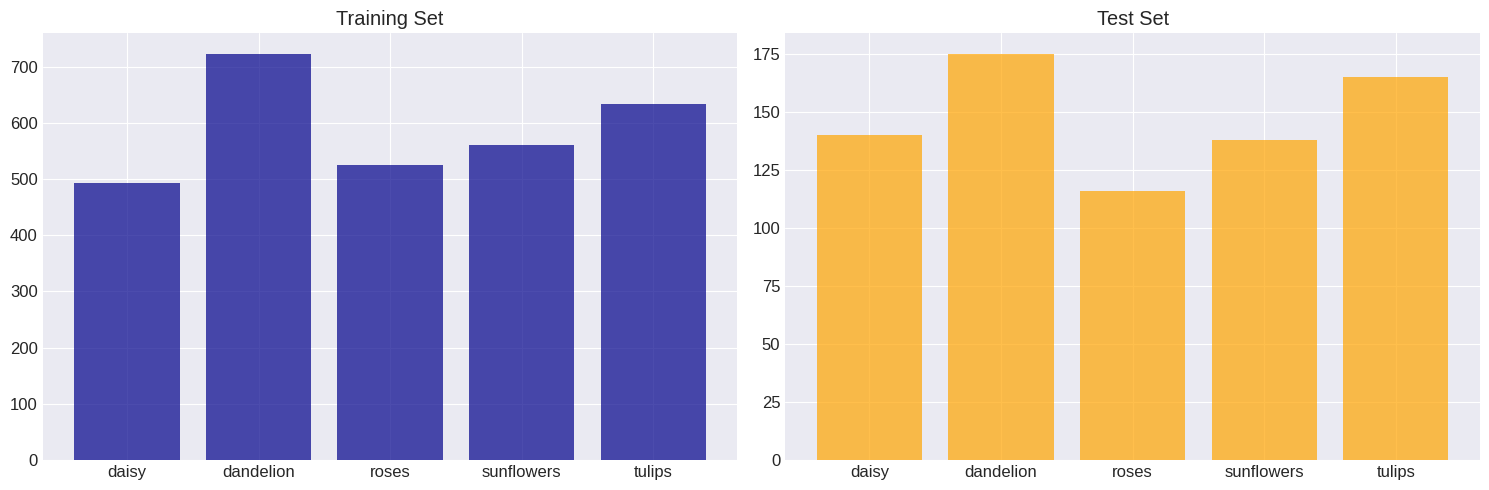

In [114]:
fn_plot_label(train_ds, test_ds)

In [115]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
input_shape

(188, 188, 3)

## Data Augmentation

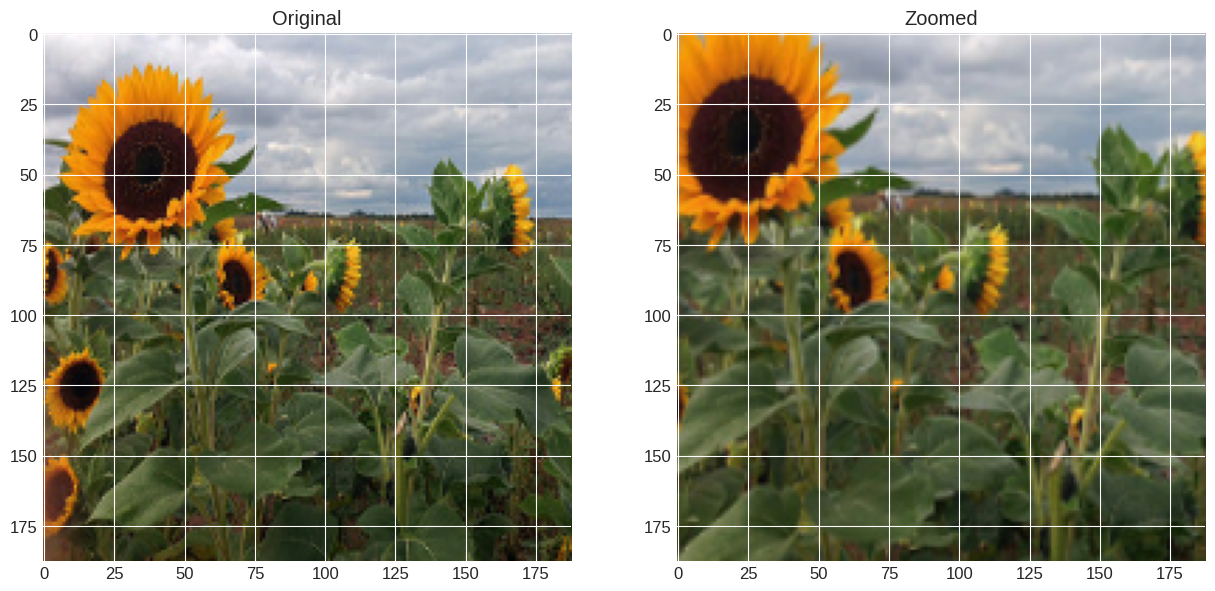

In [116]:
layer = tf.keras.layers.RandomZoom(height_factor=(-.2, -.2),
                                 width_factor=(-.2, -.2),
                                  seed = RANDOM_STATE)

# layer = tf.keras.layers.RandomRotation(
#     (-0.5,0.5),
#     fill_mode='nearest',

#     seed=RANDOM_STATE,

# )

plt.figure()

img_num = 2
for imgs, lbls in train_ds.take(1):
    out_image = layer(imgs)
    plt.subplot(1,2,1)
    plt.title('Original')
    plt.imshow(imgs[img_num].numpy().astype('uint8'))
    plt.subplot(1,2,2)
    plt.title('Zoomed')
    plt.imshow(out_image[img_num].numpy().astype('uint8'))

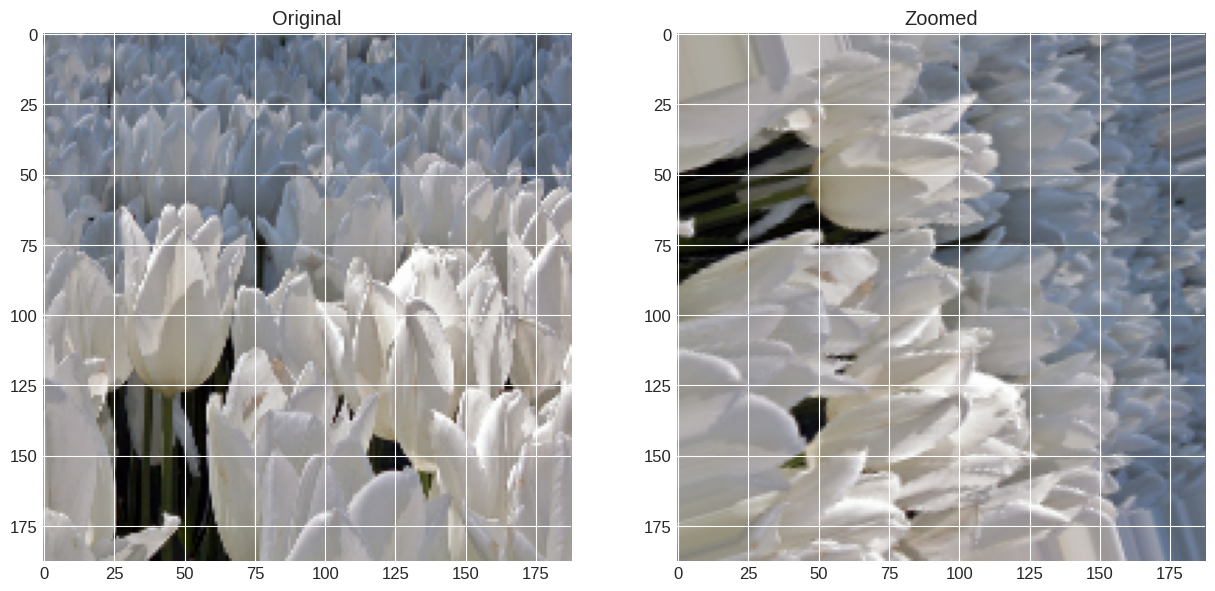

In [117]:
layer = tf.keras.layers.RandomRotation(
    (-0.5,0.5),
    fill_mode='nearest',

    seed=RANDOM_STATE,

)

plt.figure()

img_num = 2
for imgs, lbls in train_ds.take(1):
    out_image = layer(imgs)
    plt.subplot(1,2,1)
    plt.title('Original')
    plt.imshow(imgs[img_num].numpy().astype('uint8'))
    plt.subplot(1,2,2)
    plt.title('Zoomed')
    plt.imshow(out_image[img_num].numpy().astype('uint8'))

In [118]:
train_ds = train_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

## Model

* Dropout-> uniform = 0.3, val_loss = val_accuracy =

In [119]:
krnl_initializer =tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)
#krnl_reg = None
#tf.keras.regularizers.L2(l2=0.01)

krnl_regularizer = tf.keras.regularizers.L2(l2=0.001)



#Dropout
dor0 = 0.05
dor1 = 0.13
dor2 = 0.23
dor3 = 0.33
dor4 = 0.47
dor5 = 0.55
dor6 = 0.63


inputs = tf.keras.Input(shape = input_shape, name = 'input')


x = tf.keras.layers.Rescaling(1./255.)(inputs)






##....
#Set1
#conv

x = tf.keras.layers.Conv2D(64, (3,3), kernel_initializer=krnl_initializer,
                           kernel_regularizer=krnl_regularizer,

                          padding='same',

                         name = 'conv_1')(x) #o/p (188,188,64)
#batch norm
x = tf.keras.layers.BatchNormalization()(x)
#activation
x = tf.keras.layers.ReLU()(x)
#Dropout layer
#x = tf.keras.layers.Dropout()(x)

# MAxpool
x = tf.keras.layers.MaxPool2D((2, 2), name='mp_1')(x) #o/p (94,94,64)



##....
#Set2
#conv

x = tf.keras.layers.Conv2D(128, (3,3), kernel_initializer=krnl_initializer,
                           kernel_regularizer=krnl_regularizer,

                         name = 'conv_2')(x) #o/p (92,92,128)
#batch norm
x = tf.keras.layers.BatchNormalization()(x)
#activation
x = tf.keras.layers.ReLU()(x)
#Dropout layer
#x = tf.keras.layers.Dropout(dor3)(x)

# MAxpool
x = tf.keras.layers.MaxPool2D((2, 2), name='mp_2')(x) #o/p (46,46,256)



##....
#Set3
#conv

x = tf.keras.layers.Conv2D(256, (3,3), kernel_initializer=krnl_initializer,
                           kernel_regularizer=krnl_regularizer,

                         name = 'conv_3')(x) #o/p (44,44,256)
#batch norm
x = tf.keras.layers.BatchNormalization()(x)
#activation
x = tf.keras.layers.ReLU()(x)
#Dropout layer
#x = tf.keras.layers.Dropout(dor3)(x)

# MAxpool
x = tf.keras.layers.MaxPool2D((2, 2), name='mp_3')(x) #o/p (22,22,512)



##....
#Set4
#conv

x = tf.keras.layers.Conv2D(512, (3,3), kernel_initializer=krnl_initializer,
                           kernel_regularizer=krnl_regularizer,

                         name = 'conv_4')(x) #o/p (20,20,512)
#batch norm
x = tf.keras.layers.BatchNormalization()(x)
#activation
x = tf.keras.layers.ReLU()(x)
#Dropout layer
#x = tf.keras.layers.Dropout(dor3)(x)

# MAxpool
x = tf.keras.layers.MaxPool2D((2, 2), name='mp_4')(x) #o/p (10,10,512)

#Set5
#conv

x = tf.keras.layers.Conv2D(1024, (3,3), kernel_initializer=krnl_initializer,
                           kernel_regularizer=krnl_regularizer,

                          name = 'conv_5')(x) #o/p (8,8,1024)

#batch norm
x = tf.keras.layers.BatchNormalization()(x)
#activation
x = tf.keras.layers.ReLU()(x)
#Dropout layer
#x = tf.keras.layers.Dropout(dor3)(x)



# MAxpool
x = tf.keras.layers.MaxPool2D((2, 2), name='mp_5')(x) #o/p (4,4,2048)


# #Set6
# #conv

x = tf.keras.layers.Conv2D(2048, (3,3), kernel_initializer=krnl_initializer,
                           kernel_regularizer=krnl_regularizer,

                          name = 'conv_6')(x) #o/p (2,2,2048)

#batch norm
x = tf.keras.layers.BatchNormalization()(x)
#activation
x = tf.keras.layers.LeakyReLU()(x)
#Dropout layer
#x = tf.keras.layers.Dropout(dor3)(x)





x = tf.keras.layers.Flatten()(x)#(8192)



x = tf.keras.layers.Dense(4096,

                         name = 'fc_1')(x)
#batch norm
x = tf.keras.layers.BatchNormalization()(x)
#activation
x = tf.keras.layers.ReLU()(x)
#Dropout layer
x = tf.keras.layers.Dropout(dor1)(x)


x = tf.keras.layers.Dense(2048,


                         name = 'fc_2')(x)
#batch norm
x = tf.keras.layers.BatchNormalization()(x)
#activation
x = tf.keras.layers.ReLU()(x)
#Dropout layer
x = tf.keras.layers.Dropout(dor2)(x)





outputs = tf.keras.layers.Dense(5,
                             activation='softmax', name = 'output')(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs, name = 'Flowers')
model.summary()





Model: "Flowers"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 188, 188, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_6 (Rescaling)              │ (None, 188, 188, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, 188, 188, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_49               │ (None, 188, 188, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_43 (ReLU)                      │ (None, 188, 188, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mp_1 (MaxPooling2D)                  │ (None, 94, 94, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 92, 92, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_50               │ (None, 92, 92, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_44 (ReLU)                      │ (None, 92, 92, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mp_2 (MaxPooling2D)                  │ (None, 46, 46, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_3 (Conv2D)                      │ (None, 44, 44, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_51               │ (None, 44, 44, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_45 (ReLU)                      │ (None, 44, 44, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mp_3 (MaxPooling2D)                  │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_4 (Conv2D)                      │ (None, 20, 20, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_52               │ (None, 20, 20, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_46 (ReLU)                      │ (None, 20, 20, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mp_4 (MaxPooling2D)                  │ (None, 10, 10, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_5 (Conv2D)                      │ (None, 8, 8, 1024)          │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 67,147,141 (256.15 MB)

 Trainable params: 67,126,789 (256.07 MB)

 Non-trainable params: 20,352 (79.50 KB)

In [120]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False)

optimizer = tf.keras.optimizers.Adam(learning_rate = ALPHA)

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [121]:
chkptFilePath = os.path.join(modelDir, subDir, f'{altName}.weights.h5')
PATIENCE = 30

mcb = tf.keras.callbacks.ModelCheckpoint(chkptFilePath,
                                        monitor = 'val_loss',
                                        verbose = 1,
                                        save_best_only = True,
                                        save_weights_only = True)

escb = tf.keras.callbacks.EarlyStopping(patience = PATIENCE,
                                       verbose = 1,
                                       restore_best_weights = True)

lrcb = tf.keras.callbacks.ReduceLROnPlateau(factor = LR_FACTOR,
                                           patience = LR_PATIENCE,
                                           verbose = 1)

In [122]:

history = model.fit(train_ds, epochs=EPOCHS,
                    callbacks = [mcb, escb, lrcb],
                    validation_data=test_ds,
                   verbose = 1)

# results and inferences
hist_df = pd.DataFrame(history.history)

display(hist_df.head(3))
display(hist_df.tail(3))



Epoch 1/60
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.4378 - loss: 4.9034
Epoch 1: val_loss improved from inf to 4.32246, saving model to ./models/flower_photos/base_model.weights.h5
184/184 ━━━━━━━━━━━━━━━━━━━━ 81s 342ms/step - accuracy: 0.4381 - loss: 4.9004 - val_accuracy: 0.2384 - val_loss: 4.3225 - learning_rate: 0.0010
Epoch 2/60
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5505 - loss: 3.1825
Epoch 2: val_loss improved from 4.32246 to 2.83985, saving model to ./models/flower_photos/base_model.weights.h5
184/184 ━━━━━━━━━━━━━━━━━━━━ 70s 347ms/step - accuracy: 0.5506 - loss: 3.1810 - val_accuracy: 0.4005 - val_loss: 2.8399 - learning_rate: 0.0010
Epoch 3/60
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5771 - loss: 2.2083
Epoch 3: val_loss improved from 2.83985 to 2.34841, saving model to ./models/flower_photos/base_model.weights.h5
184/184 ━━━━━━━━━━━━━━━━━━━━ 66s 258ms/step - accuracy: 0.5771 - loss: 2.2076 - val_accuracy: 0.4319 - val_loss: 2.

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.491144,4.349214,0.238420,4.322463,0.001
1,0.564373,2.900079,0.400545,2.839854,0.001
2,0.580722,2.081371,0.431880,2.348410,0.001


,accuracy,loss,val_accuracy,val_loss,learning_rate
57,1.0,0.193008,0.782016,1.267038,0.000001
58,1.0,0.192295,0.783379,1.266481,0.000001
59,1.0,0.191513,0.786104,1.268346,0.000001


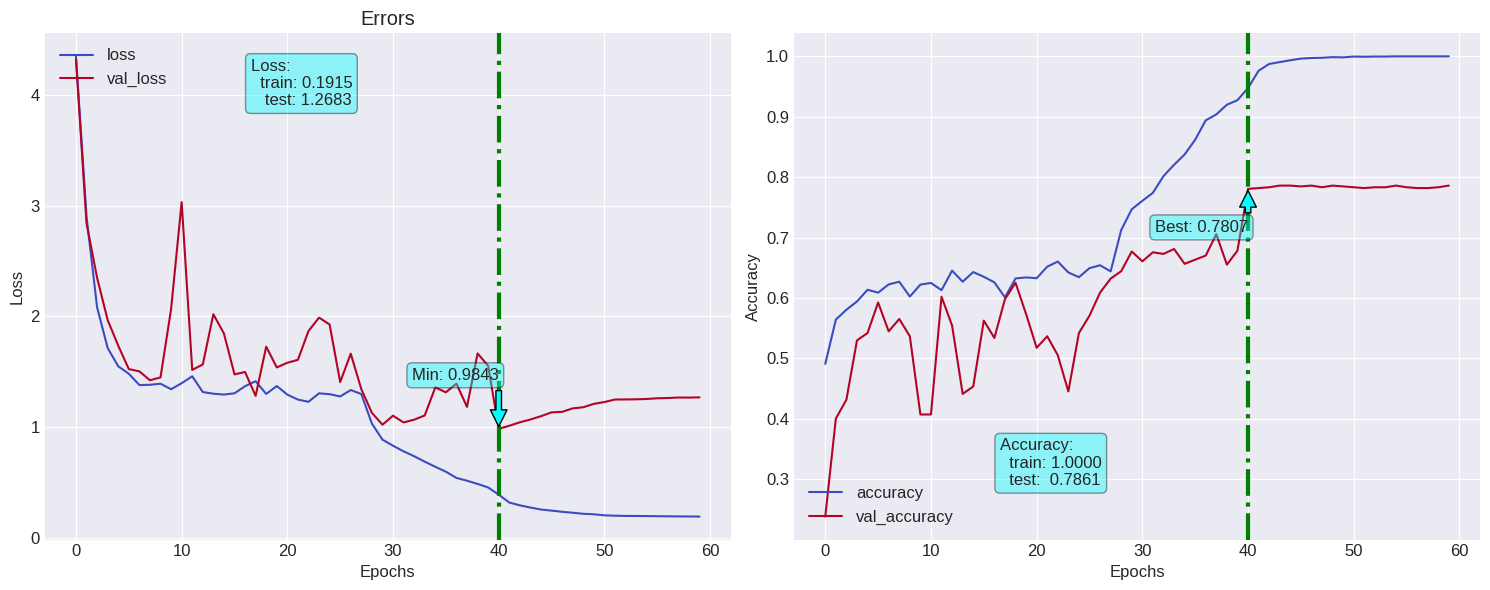

In [123]:
fn_plot_tf_hist(hist_df = hist_df)


### Evaluate the model

## Validate on the validation set